### GMSH+FEM

In [71]:
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [1]:
from zeroheliumkit import Structure, Rectangle, Square, Ring, Circle
from zeroheliumkit.src.settings import GRAY, BLUE, YELLOW2
from zeroheliumkit.src.plotting import ColorHandler

In [2]:
save_dir = "dump"

### Creating geometry

<AxesSubplot:>

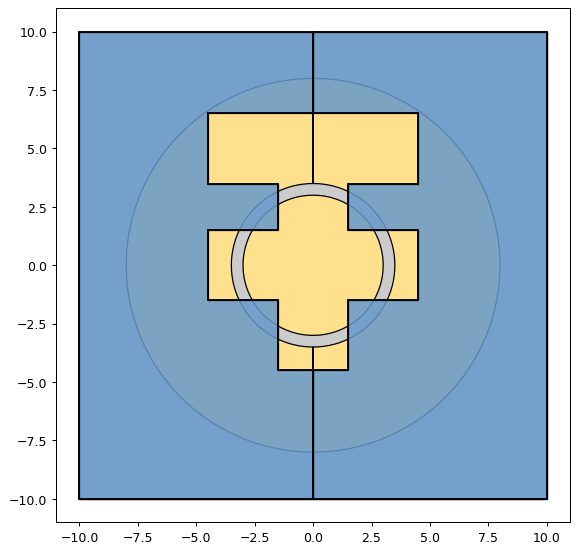

In [5]:
device = Structure()
device.add_layer("wafer", Square(20))
device.add_layer("gnd", Square(20))
device.cut_polygon("gnd", Rectangle(3, 9))
device.cut_polygon("gnd", Rectangle(9, 3))
device.cut_polygon("gnd", Rectangle(9, 3, (0,5)))
device.add_layer("bottom", Circle(3))
device.add_polygon("bottom", Ring(3.5, 8))
device.add_layer("etch", Square(20))
device.cut_polygon("etch", device.gnd)

device.remove_holes_from_polygons("bottom")
device.remove_holes_from_polygons("gnd")
plot_config = {'wafer':GRAY,'bottom':YELLOW2,'gnd':(BLUE,0.85)}

device.quickplot(plot_config)

### **Creating Mesh**

In [6]:
from zeroheliumkit.fem import *

In [7]:
# extrude parameters
d_wafer     = 10
d_metal1    = 0.2
d_metal2    = 0.1
d_diel      = 1.5
d_vac       = 20
d_He        = d_diel + d_metal2

In [8]:
Volumes = {
    'wafer':        gmshLayer_info('wafer', -d_wafer, d_wafer, 'DIELECTRIC'),
    'trap':         gmshLayer_info('bottom', 0, d_metal1, 'METAL'),
    'dielectric':   gmshLayer_info('gnd', 0, d_diel, 'DIELECTRIC', ('trap',)),
    'top':          gmshLayer_info('gnd', d_diel, d_metal2, 'METAL'),
    'helium':       gmshLayer_info('wafer', 0, d_He, 'HELIUM', ('trap', 'dielectric','top')),
    'vacuum':       gmshLayer_info('wafer', d_He, d_vac, 'VACUUM', ('dielectric', 'top'))
}

PECs = {
    'mid':   physSurface_info('bottom', [0], 'trap'),
    'out':   physSurface_info('bottom', [1,2], 'trap'),
    'top':   physSurface_info('gnd', [0,1], 'top'),
}

scale = 4 # scaling factor for meshing. default 1.8

mediumregion_box = [-10, 10, 10, 10, -5, 5] #(xmin,xmax,ymin,ymax,zmin,zmax)
fineregion_box = [-8, 8, -8, 8, -2, 2]
mesh_params = [{"Thickness": 4, "VIn": scale * 0.4, "VOut": 1*scale, "box": mediumregion_box},
               {"Thickness": 2, "VIn": scale * 0.2, "VOut": 1*scale, "box": fineregion_box}
              ]


In [9]:
save_dir = 'dump/'
mshID = 'HeliumProfile'
meshMKR =  GMSHmaker(layout=device, 
                     extrude_config=Volumes, 
                     electrodes_config=PECs, 
                     mesh_params=mesh_params)
meshMKR.create_geo(save_dir+mshID )
meshMKR.create_mesh(save_dir+mshID, dim=3)
meshMKR.open_gmsh()
meshMKR.finalize()

on 0: mesh is constructed                                                       
on 0: mesh saved                                                                
Gmsh generation  |███| 1/1 [100%] in 1.0s (0.99/s)                              


### **Helium Surface Displacement calculations**

<AxesSubplot:>

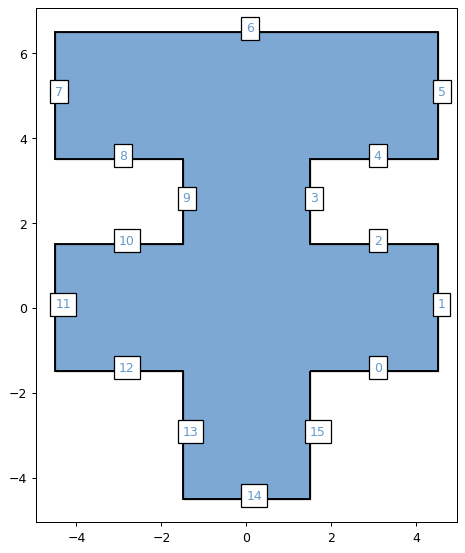

In [10]:
s = Structure()
s.add_layer("gnd", device.etch)
s.quickplot(plot_config,show_line_idx=True)

# We want to make boundary with line id 1 and 11 to be open boundary (Neumann boundary),
# at all other boundaries displacement is set to 0 (Dirichlet boundary)

In [11]:
from zeroheliumkit.fem.heliumsurface import GMSHmaker2D, HeliumSurfaceFreeFEM

In [12]:
gmshmkr = GMSHmaker2D(layout = s,
                      electode_config = {"type": "polygon",
                                         "bound": {"layer": ("gnd", (0,)), "exclude": [1,11], "value": 0}},
                      mesh_config = [{"Thickness": 5, "VIn": 0.9, "VOut": 0.9, "box": [-20, -10, 20, 10]}],
                      filename = "heliumsurface",
                      savedir = save_dir)
gmshmkr.disable_consoleOutput()
gmshmkr.create_mesh()
gmshmkr.open_gmsh()
gmshmkr.finalize()

Gmsh generation  |███| 1/1 [100%] in 0.1s (8.78/s)                              


In [14]:
pip install -e ./lib/pyFreeFEM-master/pyFreeFem

Obtaining file:///C:/Users/LyonLab/Documents/GitHub/LyonLabCodebase/femSims/Tiffany/HeliumProfile/lib/pyFreeFEM-master/pyFreeFem
Note: you may need to restart the kernel to use updated packages.


ERROR: file:///C:/Users/LyonLab/Documents/GitHub/LyonLabCodebase/femSims/Tiffany/HeliumProfile/lib/pyFreeFEM-master/pyFreeFem does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.

[notice] A new release of pip available: 22.2.2 -> 25.3
[notice] To update, run: C:\Users\LyonLab\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [15]:
import sys
sys.path.append('C:/Users/LyonLab/Documents/GitHub/LyonLabCodebase/femSims/Tiffany/HeliumProfile/lib/pyFreeFem-master/pyFreeFem')
import pyFreeFem as pyff

In [67]:
script = pyff.edpScript(hsfreefem.create_edp(hsfreefem.fem_config['savedir']))
script += """fespace Vh2(heliumsurfTh,P1);\n"""
script += """Vh2 dispOutput = disp;\n"""
script += pyff.OutputScript( heliumsurfTh = 'mesh' )
script += pyff.OutputScript( dispOutput = 'vector' )
script.get_edp()
#hsfreefem.plot_results(ff, bulk_helium_distance=0.01)

'\n/////////////////////////////\n//\n//    UNNAMED BLOCK START\n//\n/////////////////////////////\n\nload "gmsh"\nmesh heliumsurfTh = gmshload("dump/heliumsurface.msh2");\ncout << "Area: " << int2d(heliumsurfTh)(1.0) << endl;\n\nfespace heliumsurfVh(heliumsurfTh,P2);\nheliumsurfVh<real> disp,vdisp;\nproblem HeliumSurfaceCalculate(disp,vdisp,solver=CG) =\n    int2d(heliumsurfTh)( (dx(disp)*dx(vdisp) + dy(disp)*dy(vdisp)) )\n    - int2d(heliumsurfTh)( 1*vdisp )\n    + on (2,disp=0);\n\nHeliumSurfaceCalculate;\nheliumsurfTh = adaptmesh( heliumsurfTh, disp, hmax = .5, hmin = 0.02, iso = 1, nbvx = 10000 );\nHeliumSurfaceCalculate;\ncout << "Helium Surface Calculations are finished" << endl;\n\n\n\n/////////////////////////////\n//\n//    UNNAMED BLOCK END\n//\n/////////////////////////////\n\n\n/////////////////////////////\n//\n//    UNNAMED BLOCK START\n//\n/////////////////////////////\n\nfespace Vh2(heliumsurfTh,P1);\n\n\n\n/////////////////////////////\n//\n//    UNNAMED BLOCK END\n//

In [13]:
hsfreefem = HeliumSurfaceFreeFEM(fem_config=gmshmkr.export_physical(), save_edp=True)
res = hsfreefem.run_pyfreefem()

# plotting results of helium surface displacement for a bulk helium distance of 10 cm from the gnd surface
# note: the geometry units are in micrometers, so the bulk helium distance is set to 0.01 (10 cm)
hsfreefem.plot_results(ff, bulk_helium_distance=0.01)


-------------------
FreeFem++ error :
-------------------

-------------------

Corresponding line in FreeFem script:

Could not get corresponding line.



AttributeError: 'NoneType' object has no attribute 'split'

In [ ]:
hsfreefem.plot_results(res, bulk_helium_distance=0.01)

In [ ]:
curvature_config = hsfreefem.get_code_config(bulk_helium_distances=[0, 0.001, 0.01, 0.02], surface_helium_level=d_He)
# curvature_config

### **Creating FreeFem configuration**

In [21]:
from zeroheliumkit.fem.freefemer import FFconfigurator, ExtractConfig, FreeFEM

ImportError: cannot import name 'FFconfigurator' from 'zeroheliumkit.fem.freefemer' (c:\users\lyonlab\documents\github\lyonlabcodebase\femsims\tiffany\heliumprofile\lib\zeroheliumkit_0.5.0_win\zeroheliumkit\fem\freefemer.py)

In [17]:
He_level = d_He

var_eps = {
        'DIELECTRIC': 11.0,
        'METAL': 1.0,
        'HELIUM': 1.057,
        'VACUUM': 1.0,
}

ffc = FFconfigurator(config_file="dump/dot.yaml",
                     dielectric_constants=var_eps,
                     ff_polynomial=2,
                     extract_opt=[ExtractConfig("result1", 'phi', 'xy', (-10,10,201), (-10,10,201), d_He),
                                  ExtractConfig("result2", 'phi', 'xy', (-10,10,201), (-10,10,201), curvature_config),
                                  ExtractConfig("result3", 'Ez', 'yz', (-10,10,101), (-2,2,101), 0.0)
                                  ],
                     msh_refinements=None
                     )

In [18]:
pyff = FreeFEM(config_file="dump/dot.yaml")

In [19]:
await pyff.run(cores=3, remove=True)

HTML(value='<b>⏳ Running:</b> dump/edp/ff_mid.edp', layout=Layout(margin='4px 0'))

HTML(value='<b>⏳ Running:</b> dump/edp/ff_out.edp', layout=Layout(margin='4px 0'))

HTML(value='<b>⏳ Running:</b> dump/edp/ff_top.edp', layout=Layout(margin='4px 0'))

### **Parsing FEM results**

In [20]:
from zeroheliumkit.fem.fieldreader import FreeFemResultParser, FieldAnalyzer
from zeroheliumkit.src.settings import BLACK, WHITE

In [21]:
ffparser = FreeFemResultParser("dump/metadata.yaml")

                result1        result2                 result3
--------------  -------------  ----------------------  -------------
Quantity        phi            phi                     Ez
Plane           xy             xy                      yz
X Min           -10            -10                     -10
X Max           10             10                      10
X Num           201            201                     101
Y Min           -10            -10                     -2
Y Max           10             10                      2
Y Num           201            201                     101
Slices          1              4                       1
Slice Values    [1.6]          [0, 0.001, 0.01, 0.02]  [0.0]
Curved Surface  False          True                    False
Schema          (1, 201, 201)  (4, 201, 201)           (1, 101, 101)
Control Electrodes: ['mid', 'out', 'top']


In [22]:
ffparser.get_capacitance_matrix()

[[-321.911, 267.056, 67.7761],
 [258.487, -1860.69, 1726.83],
 [63.425, 1593.63, -1794.6]]

In [23]:
fa = FieldAnalyzer(("dot", ffparser.load_data("dump/results", "result1")),
                   ("curved", ffparser.load_data("dump/results", "result2")))

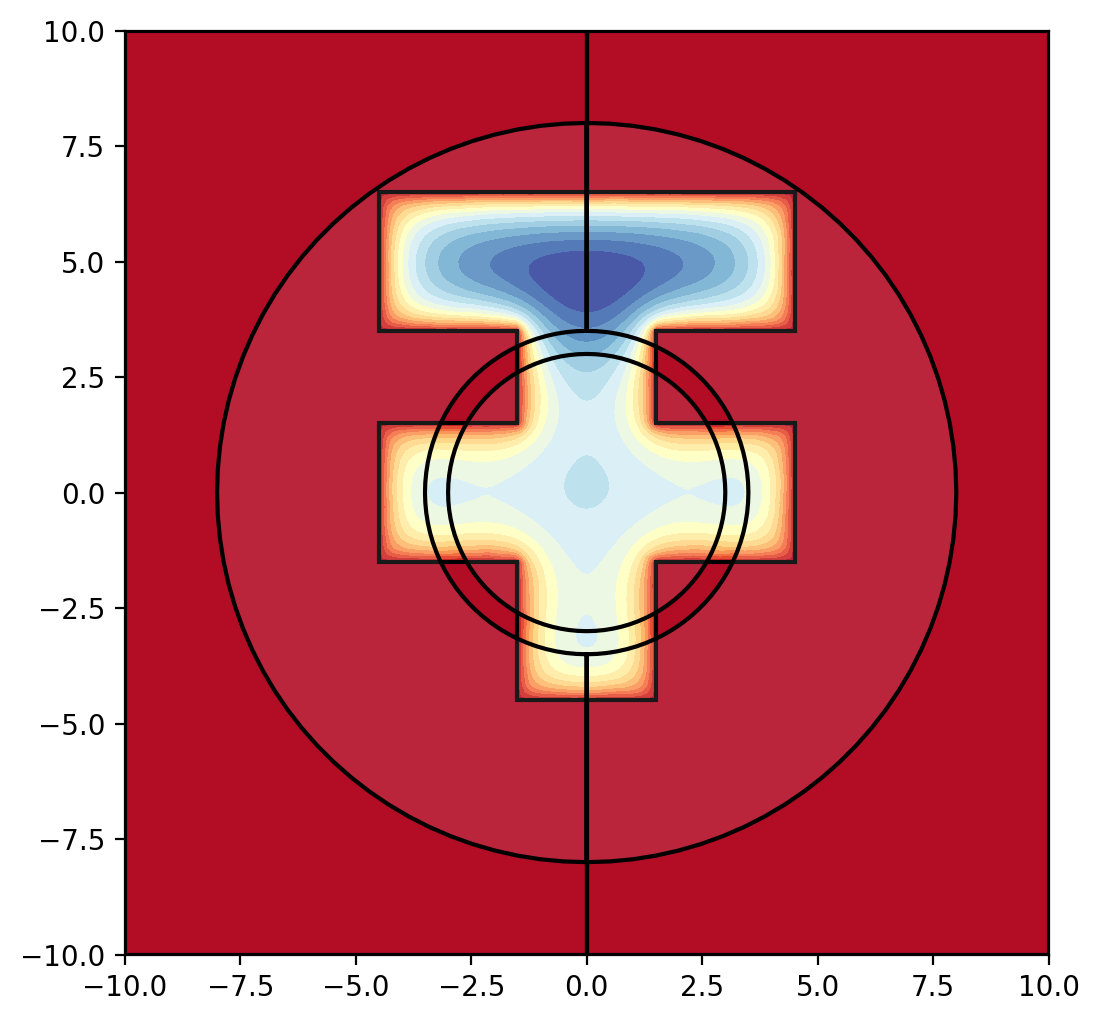

In [24]:
voltages = {
    "mid": 1,
    "out": 2,
    "top": -0.1
}

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

fa.plot_potential_2D(fa.dot, voltages, zlevel_key=1.6, ax=ax, zero_line=False, cmap='RdYlBu')
device.plot(ax=ax, layer=["gnd"], color=[BLACK], alpha=0)
device.plot(ax=ax, layer=["bottom"], color=[WHITE], alpha=0.1)

ax.set_aspect("equal")

plt.show()

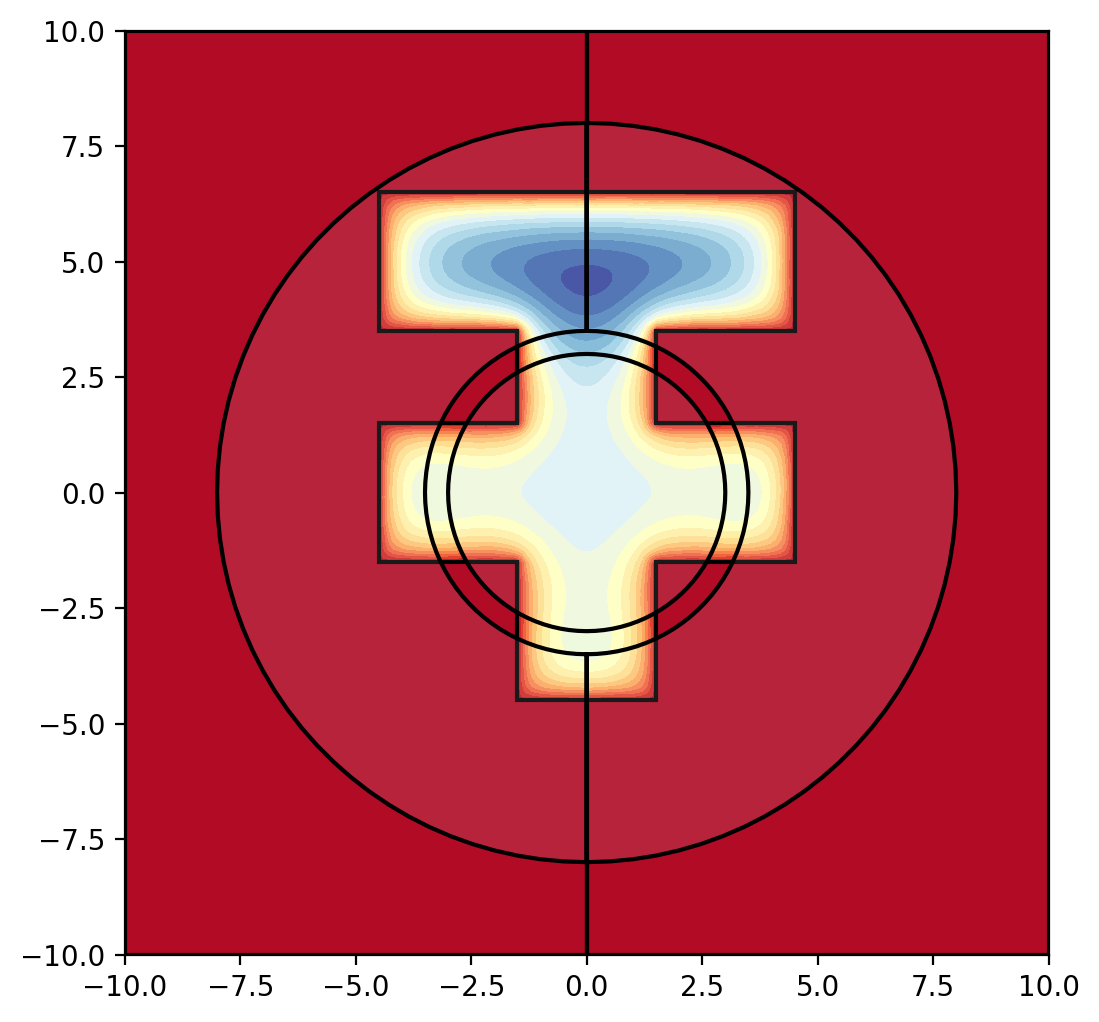

In [25]:
voltages = {
    "mid": 1,
    "out": 2,
    "top": -0.1
}

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

fa.plot_potential_2D(fa.curved, voltages, zlevel_key=0.02, ax=ax, zero_line=False, cmap='RdYlBu')
device.plot(ax=ax, layer=["gnd"], color=[BLACK], alpha=0)
device.plot(ax=ax, layer=["bottom"], color=[WHITE], alpha=0.1)

ax.set_aspect("equal")

plt.show()